In [1]:
using LinearAlgebra
using Distributions
using Optim
using Random
using StatsFuns
using JuMP
using MosekTools
using StatsBase
using SparseArrays 
using FileIO
using JLD2
using Plots
using LaTeXStrings
using DataFrames, Colors
using StatsPlots   

include("Params_PLD.jl")
include("Data_Generation_PLD.jl")
include("Estimation_PLD.jl")
include("Estimation_PLD_Fast.jl")
include("Models_PLD.jl")
include("Evaluation_PLD.jl")
include("Implement_All_Methods_PLD.jl")
include("Figures_PLD.jl")

hist_profit_distribution (generic function with 1 method)

In [2]:
Params = get_default_params_PLD()
N = Params["N"] # number of products
N_x = Params["N_x"] # dimension of product features
c_l = Params["c_l"] 
d_r = Params["d_r"]
rev_gap = Params["rev_gap"]
N_u = Params["N_u"] # dimension of customer features
S_train = Params["S_train"] # training data size
S_test = Params["S_test"] # test data size
N_Max = Params["N_Max"] # maximum assortment size
N_nonzero = Params["N_nonzero"] # number of nonzero entries in A
Time_Limit = Params["Time_Limit"] # time limit for optimization
dual_norm = Params["dual_norm"] # dual norm for robust optimization
gamma_list = Params["gamma_list"] # list of gamma values for robust optimization
psi_lb = Params["psi_lb"] # lower bound for psi
psi_ub = Params["psi_ub"] # upper bound for psi
phi_lb = Params["phi_lb"]   # lower bound for phi
phi_ub = Params["phi_ub"]  # upper bound for phi
num_c = Params["num_c"] # number of customer segments
instances = Params["instances"] # number of instances
seed = Params["seed"] # random seed
coef_this = Params["coef_this"] # coefficient for data generation
coef_Wang_Qi_Shen = Params["coef_Wang_Qi_Shen"] # coefficient for Wang, Qi, Shen data generation

(alp0_lb = 1.0, alp0_ub = 2.0, alp_lb = -1.0, alp_ub = 1.0, beta_lb = -2.0, beta_ub = 2.0, A_lb = -2.0, A_ub = 2.0, r0_lb = 0.0, r0_ub = 1.0, r_lb = -1.0, r_ub = 1.0)

In [3]:
Random.seed!(seed)
is_Wang_Qi_Shen = true;
is_same_util_para = true;
if is_Wang_Qi_Shen
    coef_para_Input = coef_Wang_Qi_Shen;
    project_dir = "Wang_Qi_Shen_N=$(N)_N_x=$(N_x)_N_u=$(N_u)_N_nonzero=$(N_nonzero)_dr=$(d_r[1])_seed=$(seed)"
else
    coef_para_Input = coef_this;
    project_dir = "N=$(N)_N_x=$(N_x)_N_u=$(N_u)_N_nonzero=$(N_nonzero)_dr=$(d_r[1])_seed=$(seed)"
end
if is_same_util_para
    println("Generate data with the same utility parameters for all instances.")
    theta_true_Fixed, r_params_Fixed = Generate_Wang_Qi_Max_True_Paras(N_x,N_u,N_nonzero,coef_para_Input);
    project_dir = string(project_dir, "_Same_Util_Para/")
else
    println("Generate data with different utility parameters for all instances.")
    project_dir = string(project_dir, "_Diff_Util_Para/")
end
current_dir = pwd()
parent_dir = dirname(current_dir)
grand_pa_dir = dirname(parent_dir)
data_dir = string(dirname(grand_pa_dir), "/Data/Product_Line_Design_ECP_Estimation/")

data_dir = string(data_dir,project_dir)
if !isdir(data_dir)
    mkpath(data_dir)
end
println("Data directory: ", data_dir)
save(string(data_dir, "Params.jld2"), Params);

Generate data with the same utility parameters for all instances.
Data directory: /Users/zhangxun/Dropbox/Research/Robust_Logit_Based_Analytics/Data/Product_Line_Design_ECP_Estimation/Wang_Qi_Shen_N=3_N_x=8_N_u=1_N_nonzero=5_dr=2.0_seed=2_Same_Util_Para/


In [4]:
function compute_w(params,z_input)
    alpha0 = params.alpha0
    alpha = params.alpha
    beta = params.beta
    A = params.A
    nu0 = alpha0 + beta' * z_input;
    nu = alpha .+ A * z_input;
    return nu0,nu
end

compute_w (generic function with 1 method)

### Lambda = 0.0

In [5]:
is_ridge = false
lambda = 0.0
S_train_list = [50, 100, 200]

3-element Vector{Int64}:
  50
 100
 200

In [ ]:
S_train_list = [50]
gamma_list = [0.0,0.1,0.2,0.4,0.6,0.8,1.0]
psi_lb = -50 * ones(Params["N"])
psi_ub = 0 * ones(Params["N"])
phi_lb = -50 * ones(Params["N"])
phi_ub = 0 * ones(Params["N"])
norm_bounds = 10
Time_Limit = 360
instances = 1

1

In [7]:
for S_train in S_train_list
    println("********** S_train = ",S_train," **********")

    Input_Data = Dict()
    RST_True_All = Dict()
    RST_ETO_All = Dict()
    RST_RO_All = Dict()
    ins = 1
    while ins <= instances
        # ******** Data generation *************
        if is_same_util_para
            Input_Data_this = Generate_Data_this_Same_Para(N_Max,N_x,N_u,S_train,S_test,theta_true_Fixed, r_params_Fixed);
        else
            Input_Data_this = Generate_Data_this(N_x,N_u,N_nonzero,S_train,S_test,m,coef_para_Input)
        end
        theta_true,r_params,X_train,Y_train,Z_train,Asorrtment_train,X_test,Y_test,Z_test = Get_Input_Data(Input_Data_this);
        nu0_true,nu_true = compute_w(theta_true,Z_test[1,:])  
        nu_all_true = [nu0_true;nu_true]

        # ******** Estimation *************
        theta_hat = Estimation_This(N_Max,N_x,N_u,Y_train,X_train,Z_train, Asorrtment_train,is_ridge, lambda)
        nu0_hat,nu_hat = compute_w(theta_hat,Z_test[1,:])  
        nu_all_hat = [nu0_hat;nu_hat]
        if any(isnan, nu_all_hat)
            println("Estimate contains NaN values.")
            continue
        end
        if norm(vec(nu_all_true .- nu_all_hat),2) >= norm_bounds
            println("Estimate is too far from true parameters.")
            continue
        end
        Input_Data_this["theta_hat"] = theta_hat
        Input_Data_this["nu_true"] = nu_all_true
        Input_Data_this["nu_hat"] = nu_all_hat
        Input_Data["ins=$(ins)"] = Input_Data_this

        # ******** True Model *************
        theta_Input = theta_true
        RST_True,status_True = solve_ETO_This(S_test,N,N_x,theta_Input,theta_true,r_params,c_l,d_r,rev_gap,num_c,Time_Limit,Z_test)
        # println("Oracle: status = ",status_True,",obj=",RST_True["obj"][1])
        if status_True != "OPTIMAL"
            println("Warning: The true model did not reach optimality")
            continue
        end
        RST_True_All["ins=$(ins)"] = RST_True

        # ******** ETO Model *************
        RST_ETO,status_ETO = solve_ETO_This(S_test,N,N_x,theta_hat,theta_true,r_params,c_l,d_r,rev_gap,num_c,Time_Limit,Z_test)
        # println("ETO: status = ",status_ETO,",obj=",RST_ETO["obj"][1])
        if status_ETO != "OPTIMAL"
            println("Warning: The ETO model did not reach optimality")
            continue
        end
        RST_ETO_All["ins=$(ins)"] = RST_ETO
        
        # ******** RO Model *************
        RST_RO_this = Dict()
        gamma = gamma_list[1]
        RST_RO,status_RO = solve_RO_this(S_test,N,N_x,theta_hat,theta_true,r_params,c_l,d_r,rev_gap,num_c,Time_Limit,Z_test,gamma,psi_lb,psi_ub,phi_lb,phi_ub)
        # println("gamma = $gamma, RO: status = ",status_RO,",obj=",RST_RO["obj"][1])
        if status_RO != "OPTIMAL"
            println("Warning: The RO model did not reach optimality")
            continue
        end
        ratio = abs(RST_RO["obj"][1] - RST_ETO["obj"][1])/abs(RST_ETO["obj"][1])
        # ratio = abs(RST_RO["profit"][1] - RST_ETO["profit"][1])/abs(RST_ETO["profit"][1])
        if ratio > 1e-4
            println("Warning: The RO obj is not equivalent to ETO obj")
            continue
        end
        RST_RO_this[string("gamma=",gamma)] = RST_RO

        for g_index in 2:length(gamma_list)
            gamma = gamma_list[g_index]
            RST_RO,status_RO = solve_RO_this(S_test,N,N_x,theta_hat,theta_true,r_params,c_l,d_r,rev_gap,num_c,Time_Limit,Z_test,gamma,psi_lb,psi_ub,phi_lb,phi_ub)
            # println("gamma = $gamma, RO: status = ",status_RO,",obj=",RST_RO["obj"][1])
            RST_RO_this[string("gamma=",gamma)] = RST_RO
        end
        RST_RO_All["ins=$(ins)"] = RST_RO_this
        println("******* ins = ",ins,"*********")
        ins = ins + 1
    end
    save(string(data_dir, "Input_Data_S=$(S_train)_lambda=$(lambda).jld2"), Input_Data);
    save(string(data_dir, "RST_True_S=$(S_train)_lambda=$(lambda).jld2"), RST_True_All);
    save(string(data_dir, "RST_ETO_S=$(S_train)_lambda=$(lambda).jld2"), RST_ETO_All);
    save(string(data_dir, "RST_RO_S=$(S_train)_lambda=$(lambda).jld2"), RST_RO_All);
end

********** S_train = 50 **********
******* ins = 1*********


## S = 50

In [8]:
S_train = 50
Input_Data = load(string(data_dir, "Input_Data_S=$(S_train)_lambda=$(lambda).jld2"));
RST_True_All = load(string(data_dir, "RST_True_S=$(S_train)_lambda=$(lambda).jld2"));
RST_ETO_All = load(string(data_dir, "RST_ETO_S=$(S_train)_lambda=$(lambda).jld2"));
RST_RO_All = load(string(data_dir, "RST_RO_S=$(S_train)_lambda=$(lambda).jld2"));

In [9]:
gamma_list = sort([parse(Float64, split(k, "=")[end]) for k in keys(RST_RO_All["ins=1"])])
gamma_list = gamma_list
println("Gamma list: ", gamma_list)

Gamma list: [0.0, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0]


In [10]:
obj_True, obj_ETO, obj_RO = obtain_obj(RST_True_All, RST_ETO_All, RST_RO_All, instances, gamma_list);
println("obj True:",round.(mean(obj_True),digits=4))
println("obj ETO:",round.(mean(obj_ETO),digits=4))
println("obj RO:",round.(mean(obj_RO,dims=1),digits=4))

obj True:2.0267
obj ETO:2.3025
obj RO:[2.3025 2.3025 2.3025 2.3025 2.3025 2.3025 2.3025]


In [11]:
profit_True, profit_ETO, profit_RO = obtain_profits(RST_True_All, RST_ETO_All, RST_RO_All, instances, gamma_list);
println("profit True:",round.(mean(profit_True),digits=4))
println("profit ETO:",round.(mean(profit_ETO),digits=4))
println("profit RO:",round.(mean(profit_RO,dims=1),digits=4))

profit True:2.0267
profit ETO:0.5338
profit RO:[2.1177 2.1177 2.1177 2.1177 2.1177 2.1177 2.1177]


In [12]:
println("ETO:", round.(profit_ETO,digits=2))
println("RO: ", round.(profit_RO[:,1],digits=2))

ETO:[0.53]
RO: [2.12]


In [13]:
diff = profit_ETO .- profit_RO[:,1];

In [14]:
# 找出 diff 绝对值小于 0.001 的索引
indices = findall(x -> abs(x) < 0.001, diff)

# 输出这些索引下的 profit_ETO 和 profit_RO
println("满足条件的索引数量: ", length(indices))
println("这些索引下 profit_ETO 均值: ", mean(profit_ETO[indices]))
println("这些索引下 profit_RO 均值: ", mean(profit_RO[indices, :],dims=1))

满足条件的索引数量: 0
这些索引下 profit_ETO 均值: NaN
这些索引下 profit_RO 均值: [NaN NaN NaN NaN NaN NaN NaN]


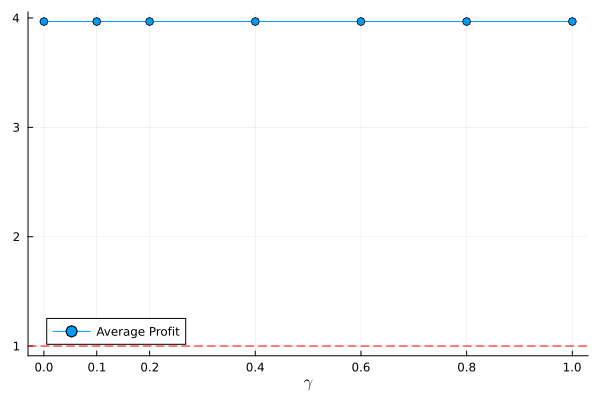

"/Users/zhangxun/Dropbox/Research/Robust_Logit_Based_Analytics/Data/Product_Line_Design_ECP_Estimation/Wang_Qi_Shen_N=3_N_x=8_N_u=1_N_nonzero=5_dr=2.0_seed=2_Same_Util_Para/RPLD_vs_ETOPLD_lambda=0.0.pdf"

In [15]:
fig_name = string(data_dir, "RPLD_vs_ETOPLD_lambda=$lambda.pdf")
include_std = false
line_plot_RPLD_vs_ETOPLD(profit_ETO,profit_RO,gamma_list,include_std,fig_name)

In [31]:
w_hat = Input_Data["ins=1"]["nu_hat"]
w_true = Input_Data["ins=1"]["nu_true"]
println("w_hat  = ",round.(w_hat,digits=4))
println("w_true = ",round.(w_true,digits=4))

w_hat  = [18.0697, 0.1108, -0.1406, -0.2708, -0.4976, 1.5142, 0.1511, 0.0412, -0.084]
w_true = [0.6336, 0.4903, -0.1327, -0.539, -0.3659, 1.119, -0.0112, 0.7176, -0.2489]


## S = 100

In [18]:
# S_train = 100
# RST_True_All = load(string(data_dir, "RST_True_S=$(S_train)_lambda=$(lambda).jld2"));
# RST_ETO_All = load(string(data_dir, "RST_ETO_S=$(S_train)_lambda=$(lambda).jld2"));
# RST_RO_All = load(string(data_dir, "RST_RO_S=$(S_train)_lambda=$(lambda).jld2"));

In [19]:
# gamma_list = sort([parse(Float64, split(k, "=")[end]) for k in keys(RST_RO_All["ins=1"])])
# gamma_list = gamma_list
# println("Gamma list: ", gamma_list)

In [20]:
# profit_True, profit_ETO, profit_RO = obtain_profits(RST_True_All, RST_ETO_All, RST_RO_All, instances, gamma_list);
# println("profit True:",round.(mean(profit_True),digits=4))
# println("profit ETO:",round.(mean(profit_ETO),digits=4))
# println("profit RO:",round.(mean(profit_RO,dims=1),digits=4))

In [21]:
# fig_name = string(data_dir, "RPLD_vs_ETOPLD_lambda=$lambda.pdf")
# include_std = false
# line_plot_RPLD_vs_ETOPLD(profit_ETO,profit_RO,gamma_list,include_std,fig_name)

## S = 200

In [22]:
# S_train = 200
# RST_True_All = load(string(data_dir, "RST_True_S=$(S_train)_lambda=$(lambda).jld2"));
# RST_ETO_All = load(string(data_dir, "RST_ETO_S=$(S_train)_lambda=$(lambda).jld2"));
# RST_RO_All = load(string(data_dir, "RST_RO_S=$(S_train)_lambda=$(lambda).jld2"));

In [23]:
# gamma_list = sort([parse(Float64, split(k, "=")[end]) for k in keys(RST_RO_All["ins=1"])])
# gamma_list = gamma_list
# println("Gamma list: ", gamma_list)

In [24]:
# profit_True, profit_ETO, profit_RO = obtain_profits(RST_True_All, RST_ETO_All, RST_RO_All, instances, gamma_list);
# println("profit True:",round.(mean(profit_True),digits=4))
# println("profit ETO:",round.(mean(profit_ETO),digits=4))
# println("profit RO:",round.(mean(profit_RO,dims=1),digits=4))

In [25]:
# fig_name = string(data_dir, "RPLD_vs_ETOPLD_lambda=$lambda.pdf")
# include_std = false
# line_plot_RPLD_vs_ETOPLD(profit_ETO,profit_RO,gamma_list,include_std,fig_name)

In [26]:
# profit_True = zeros(instances);
# profit_ETO = zeros(instances);
# profit_RO = zeros(instances, length(gamma_list));
# for ins in 1:instances
#     profit_True[ins] = mean(RST_True_All["ins=$(ins)"]["profit"])
#     profit_ETO[ins] = mean(RST_ETO_All["ins=$(ins)"]["profit"])
# end
# println("True profit: mean = ", mean(profit_True), ", std = ", std(profit_True))
# println("ETO profit: mean = ", mean(profit_ETO), ", std = ", std(profit_ETO))
# println("ETO/True Ratio = ", mean(profit_ETO)/mean(profit_True))

In [27]:
# Profit_ETO_All_Ins = profit_ETO./mean(profit_ETO)
# Profit_RO_All_Ins = Dict();
# for g_index in 1:length(gamma_list)
#     gamma=gamma_list[g_index]
#     Profit_RO_All_Ins["gamma=$(gamma)"] = profit_RO[:,g_index]./mean(profit_ETO)
# end

# chosen_indices = [1,5,7,9]
# gamma_chosen = gamma_list[chosen_indices]
# data = [Profit_ETO_All_Ins, [Profit_RO_All_Ins["gamma=$(gamma)"] for gamma in gamma_chosen]...]
# labels = ["ETO"; ["RO($gamma)" for gamma in gamma_chosen]]
# fig_name = string(data_dir, "Boxplot_RPLD_vs_ETOPLD_lambda=$(lambda)_Normalize.pdf")
# boxplot_RPLD_vs_ETOPLD(data,labels,fig_name)